In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [21]:

# Loading dataset
data = pd.read_csv('D:/nexus/dataset.csv')

In [22]:
# Drop non-numeric and irrelevant columns
data = data.drop(columns=['Patient ID', 'Country', 'Continent', 'Hemisphere'])

In [23]:
# Separating features and target
X = data.drop(columns=['Heart Attack Risk'])  # Features
y = data['Heart Attack Risk']  # Target

In [24]:
# Identifying categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()



In [25]:
# Preprocessing 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['float64', 'int64']).columns),
        ('cat', OneHotEncoder(), categorical_cols)])

# Applying preprocessing
X_preprocessed = preprocessor.fit_transform(X)

In [26]:

# Selecting top K features
selector = SelectKBest(f_classif, k=25)  # Adjust k as needed
X_selected = selector.fit_transform(X_preprocessed, y)


In [27]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True)
}

In [28]:
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Performance:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'F1 Score: {f1_score(y_test, y_pred)}\n')

Logistic Regression Performance:
Accuracy: 0.6508841985168283
Precision: 0.9444444444444444
Recall: 0.027070063694267517
F1 Score: 0.05263157894736842

Decision Tree Performance:
Accuracy: 0.6554478037649744
Precision: 0.9615384615384616
Recall: 0.03980891719745223
F1 Score: 0.0764525993883792

Random Forest Performance:
Accuracy: 0.6554478037649744
Precision: 0.9615384615384616
Recall: 0.03980891719745223
F1 Score: 0.0764525993883792

Support Vector Machine Performance:
Accuracy: 0.6554478037649744
Precision: 0.9615384615384616
Recall: 0.03980891719745223
F1 Score: 0.0764525993883792



In [29]:
# Cross-Validation
for name, model in models.items():
    scores = cross_val_score(model, X_selected, y, cv=5)
    print(f'{name} Cross-Validation Accuracy: {np.mean(scores)}\n')


Logistic Regression Cross-Validation Accuracy: 0.6487504786315436

Decision Tree Cross-Validation Accuracy: 0.6513749423688548

Random Forest Cross-Validation Accuracy: 0.6513749423688548

Support Vector Machine Cross-Validation Accuracy: 0.6513749423688548



In [30]:
# Hyperparameter Tuning
param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Decision Tree': {'max_depth': [3, 5, 7]},
    'Random Forest': {'n_estimators': [50, 100, 150]},
    'Support Vector Machine': {'C': [0.1, 1, 10]}
}

best_models = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f'{name} Best Parameters: {grid_search.best_params_}')


Logistic Regression Best Parameters: {'C': 10}
Decision Tree Best Parameters: {'max_depth': 7}
Random Forest Best Parameters: {'n_estimators': 50}
Support Vector Machine Best Parameters: {'C': 0.1}


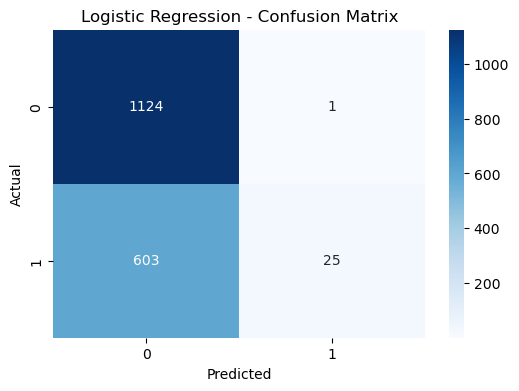

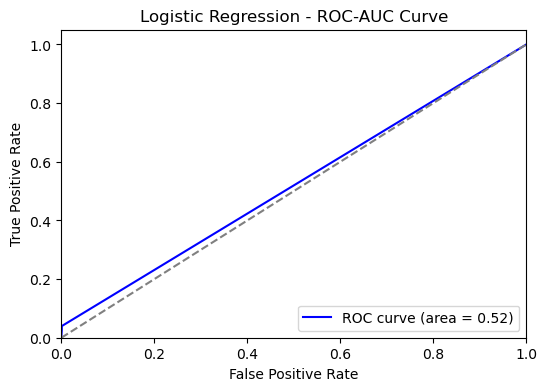

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1125
           1       0.96      0.04      0.08       628

    accuracy                           0.66      1753
   macro avg       0.81      0.52      0.43      1753
weighted avg       0.76      0.66      0.53      1753



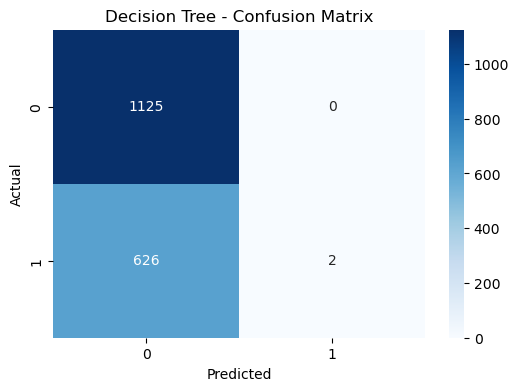

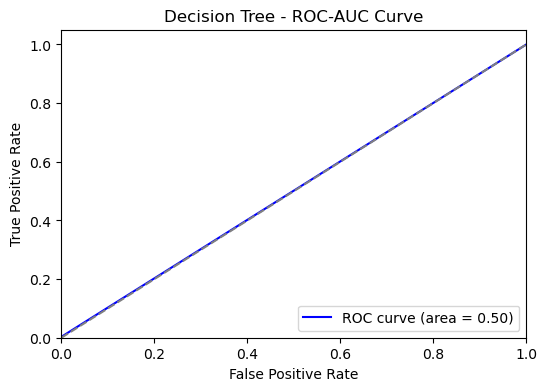

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      1125
           1       1.00      0.00      0.01       628

    accuracy                           0.64      1753
   macro avg       0.82      0.50      0.39      1753
weighted avg       0.77      0.64      0.50      1753



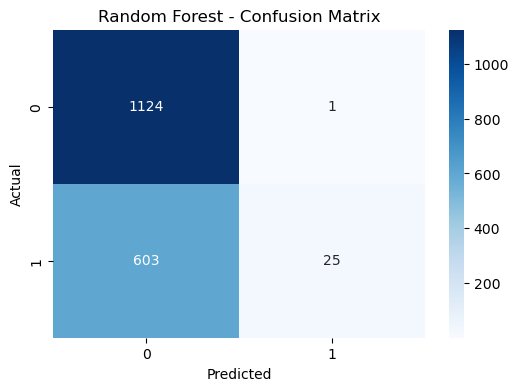

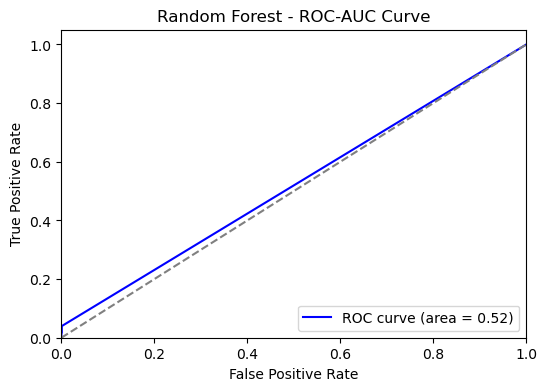

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1125
           1       0.96      0.04      0.08       628

    accuracy                           0.66      1753
   macro avg       0.81      0.52      0.43      1753
weighted avg       0.76      0.66      0.53      1753



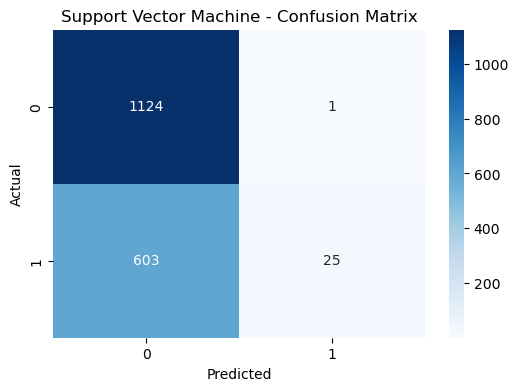

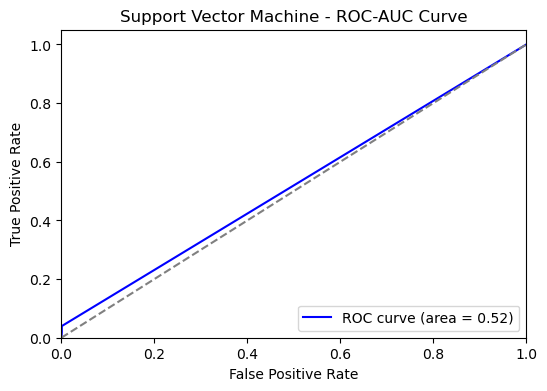

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79      1125
           1       0.96      0.04      0.08       628

    accuracy                           0.66      1753
   macro avg       0.81      0.52      0.43      1753
weighted avg       0.76      0.66      0.53      1753



In [31]:
# Validation and Testing

# Testing the best models on the test set
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # For ROC-AUC

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} - ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

    print(f'{name} Classification Report:\n{classification_report(y_test, y_pred)}')